In [147]:
import pennylane as qml
from pennylane import numpy as np
import random

def ising_model_circuit(num_qubits=6):
    # Define the device
    dev = qml.device("default.mixed", wires=num_qubits)
    
    # Define random interaction strengths and external field strengths
    J = np.array(list(np.random.uniform(-1, 1, 1))*num_qubits)
    h = np.array(list(np.random.uniform(-1, 1, 1))*num_qubits)

    def circuit(params):
        # Apply RX rotations with parameters
        for i in range(num_qubits):
            qml.RX(params[i], wires=i)
        
        # Apply Ising ZZ interactions
        for i in range(num_qubits - 1):
            qml.CRX(2 * J[i], wires=[i, i+1])

        
        # Apply external field X terms
        for i in range(num_qubits):
            qml.RX(2 * h[i], wires=i)
    
    # Define the Ising model Hamiltonian
    coeffs = []
    obs = []
    
    # ZZ interaction terms
    for i in range(num_qubits - 1):
        coeffs.append(J[i])
        obs.append(qml.PauliZ(i) @ qml.PauliZ(i + 1))
    
    # X field terms
    for i in range(num_qubits):
        coeffs.append(h[i])
        obs.append(qml.PauliX(i))
    H = qml.Hamiltonian([1,1,1,1], [qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliZ(3)])

    @qml.qnode(dev,interface='torch')
    def cost(params):
        circuit(params)
        return qml.expval(H)
    
    return cost,H

# Example usage
num_parameters = 4  # One parameter per qubit for RX rotations
params = list(np.random.uniform(0, 2 * np.pi, num_parameters))
random_circuit,H = ising_model_circuit(4)
print(random_circuit(params))
print(qml.draw(random_circuit)(params))

0.9031030418863673
0: ──RX(3.57)─╭●──────────RX(1.33)───────────────────────┤ ╭<𝓗>
1: ──RX(5.82)─╰RX(-1.92)─╭●──────────RX(1.33)────────────┤ ├<𝓗>
2: ──RX(0.45)────────────╰RX(-1.92)─╭●──────────RX(1.33)─┤ ├<𝓗>
3: ──RX(0.55)───────────────────────╰RX(-1.92)──RX(1.33)─┤ ╰<𝓗>


In [148]:
import torch

def extra_polation(circ,H,theta,noise_factor=[1,3,5],p1=0.01,p2=0.02):
    
    real_vaule = circ(theta)
    dev = circ.device
    ops = circ.qtape.operations
    ops_inv = ops[::-1]
    noise_factor = (np.array(noise_factor)+1)/2-1

    
    def noise_circ():
        tensor = torch.tensor
        for op in ops:
            eval(f'qml.{op}')
            if len(op.wires)>1:
                for wire in op.wires:
                    qml.DepolarizingChannel(p1, wires=wire)
                    qml.BitFlip(p2, wires=wire)
            else:
                qml.DepolarizingChannel(p1, wires=op.wires) 
                qml.BitFlip(p2, wires=op.wires)
    def noise_circ_inv():
        tensor = torch.tensor
        for op in ops_inv:
            eval(f'qml.adjoint(qml.{op})')
            if len(op.wires)>1:
                for wire in op.wires:
                    qml.DepolarizingChannel(p1, wires=wire)
                    qml.BitFlip(p2, wires=wire)
            else:
                qml.DepolarizingChannel(p1, wires=op.wires) 
                qml.BitFlip(p2, wires=op.wires)
    
    @qml.qnode(dev,interface='torch')
    def extra_polation(factor):
        PauliZ = qml.PauliZ
        PauliY = qml.PauliY
        PauliX = qml.PauliX
        for i in range(factor):
            noise_circ()
            noise_circ_inv()
        noise_circ()
        return qml.expval(H)
    




    res = []
    for factor in noise_factor:
        res.append(extra_polation(factor).detach().numpy())
    return res,real_vaule

def extra_polation_time(circ,H,theta,noise_factor=[1,2,3],p1=0.01,p2=0.02):
    
    real_vaule = circ(theta)
    dev = circ.device
    ops = circ.qtape.operations

    def noise_circ(factor):
        tensor = torch.tensor
        
        for op in ops:
            if len(op.wires)>1:
                """
                for wire in op.wires:
                    qml.DepolarizingChannel(p1*factor, wires=wire)
                    qml.BitFlip(p2*factor, wires=wire)"""

                eval(f'qml.{op}')
                for wire in op.wires:
                    qml.DepolarizingChannel(p1*factor, wires=wire)
                    qml.BitFlip(p2*factor, wires=wire)
            else:
                eval(f'qml.{op}')

    
    @qml.qnode(dev)
    def extra_polation(factor):
        noise_circ(factor)
        return qml.expval(H)
    res = []
    for factor in noise_factor:
        res.append(extra_polation(factor).detach().numpy())
    return res,real_vaule

In [149]:
meas1 = qml.Hamiltonian([1,1,1,1], [qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliZ(3)])
meas2 = qml.Hamiltonian([1,1,1,1], [qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliZ(3)])

In [150]:

from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader

input_list= [1,1.5,2]
# 데이터셋 생성 클래스
class QuantumData(Dataset):
    def __init__(self, size=50):
        self.data = []
        self.labels = []
        for _ in tqdm(range(size)):
            theta = [np.random.uniform(0, 2 * np.pi) for i in range(6)]
            noise_factor,result = extra_polation_time(random_circuit,H,theta,noise_factor=input_list,p1=0.1,p2=0.1)
            self.data.append(np.array(noise_factor))
            self.labels.append(result)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# 데이터셋 생성 클래스
class QuantumData_2(Dataset):
    def __init__(self, size=50):
        self.data = []
        self.labels = []
        for _ in tqdm(range(size)):
            theta = [np.random.uniform(0, 2 * np.pi) for i in range(6)]
            noise_factor,result = extra_polation_time(random_circuit,H,theta,noise_factor=input_list,p1=0.1,p2=0.1)
            self.data.append(np.array(noise_factor))
            self.labels.append(result)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


# 데이터셋 및 데이터 로더 생성
dataset = QuantumData_2(400)
#dataset_2 = QuantumData_2()
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더
train_loader = DataLoader(dataset, batch_size=15, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=15, shuffle=False)

100%|██████████| 400/400 [02:58<00:00,  2.24it/s]


In [151]:
import pickle as pkl
pkl_data = {}
pkl_data['circuit'] = qml.draw(random_circuit)(params)
pkl_data['data'] = dataset,input_list
pkl_data['inform'] = "p1=0.01,p2=0.01 로 구성되어 있고 서킷에 노이즈를 가한 결과, parameter : 초기 x gate 4개"

with open('./data/Quantum_data_2.pkl','wb') as file:
    pkl.dump(pkl_data,file)


In [152]:
# 데이터셋 및 데이터 로더 생성

train_size = int(0.5 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더
train_loader = DataLoader(dataset, batch_size=500, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)

In [129]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(len(input_list), 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)
        self.relu = nn.GELU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return torch.squeeze(self.fc3(x))

model_MLP = RegressionModel()
criterion = nn.MSELoss()
optimizer_MLP = torch.optim.Adam(model_MLP.parameters(), lr=0.01)

from kan import KAN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([len(input_list),1,1],grid=5)
    def forward(self, x):
        output = self.KAN(x)
        #output = nn.Sigmoid()(output)
        output = torch.squeeze(output)
        return output
    
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.unsqueeze(x,2)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 은닉 상태 초기화
        c0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 셀 상태 초기화
        out, _ = self.lstm(x, (h0, c0))  # LSTM을 통해 시퀀스 처리
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 fully connected layer에 적용하여 출력 생성
        return out

model = Model()
LSTM_model = LSTMModel(1, 64, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
optimizer_LSTM = torch.optim.Adam(LSTM_model.parameters(), lr=0.05)

In [130]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import copy
import pandas as pd
import pickle


def accuracy(pred, true):
    # 예측값이 로짓 혹은 확률값인 경우, 최대 값을 가진 인덱스를 구함 (가장 확률이 높은 클래스)
    pred = pred.detach().cpu()
    true = true.cpu()
    pred_labels = torch.round(pred)
    # 예측 레이블과 실제 레이블이 일치하는 경우를 계산
    correct = (pred_labels == true).sum()
    # 정확도를 계산
    acc = correct / true.size(0)
    return acc.item()

class Early_stop_train():
    def __init__(self,model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion


        
        self.stop_count = 0

    def train_model(self,train_loader,test_loader=None ,epochs=200,res = 10,device = 'cpu'):
        self.model.train()
        self.loss_list = [1e100]
        self.train_loss_list = []
        self.train_acc_list = []
        for epoch in range(epochs):
            if self.stop_count>=res:
                break
            loss_val,_ = self.test(test_loader,device)
            self.loss_list.append(loss_val)

            if self.loss_list[-1]>=np.min(self.loss_list[:-1]):
                self.stop_count+=1
            else:
                self.optimal = copy.deepcopy(self.model.state_dict())
                self.stop_count = 0
            loss_list = []
            acc_list = []
            for X_train,y_train in train_loader:
                if isinstance(X_train,list):
                    for i,X in enumerate(X_train):
                        X_train[i] = X.to(device)
                else:
                    X_train = X_train.to(device)
                y_train = y_train.to(device)
                self.optimizer.zero_grad()
                output = self.model(X_train)

                loss = self.criterion(output.squeeze(), y_train)

                loss.backward()
                self.optimizer.step()
                loss_list.append(loss.item())
                acc = accuracy(output,y_train)
                acc_list.append(acc)
                sys.stdout.write(f"\rEpoch {epoch+1} Loss {np.mean(loss_list):4f} acc : {np.mean(acc_list):4f} stop count : {self.stop_count}")
            self.train_loss_list.append(np.mean(loss_list))
            self.train_acc_list.append(np.mean(acc_list))
        self.loss_list = self.loss_list[1:]
        self.model.load_state_dict(self.optimal)
        self.loss_list = self.loss_list[1:]
    def test(self,test_loader,device='cpu'):
        if test_loader is None:
            return 0,0
        else:
            #self.model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    if isinstance(data,list):
                        for i,X in enumerate(data):
                            data[i] = X.to(device)
                    else:
                        data = data.to(device)
                    target = target.to(device)
                    data, target = data, target
                    output = self.model(data)
                    test_loss += self.criterion(output.squeeze(), target).item()

                    correct += accuracy(output,target)*len(output)

            print(f'\nTest set: Average loss: {test_loss/len(test_loader):.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')
            return test_loss/len(test_loader),correct
        
def reg(acts_scale,KAN_layer, factor=1,lamb_l1=1.,lamb_entropy=2.,lamb_coef=0.,lamb_coefdiff=0.):

    def nonlinear(x, th=1e-16):
        return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

    reg_ = 0.
    for i in range(len(acts_scale)):
        vec = acts_scale[i].reshape(-1, )

        p = vec / torch.sum(vec)
        l1 = torch.sum(nonlinear(vec))
        entropy = - torch.sum(p * torch.log2(p + 1e-4))
        reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

    # regularize coefficient to encourage spline to be zero
    for i in range(len(KAN_layer.act_fun)):
        coeff_l1 = torch.sum(torch.mean(torch.abs(KAN_layer.act_fun[i].coef), dim=1))
        coeff_diff_l1 = torch.sum(torch.mean(torch.abs(torch.diff(KAN_layer.act_fun[i].coef)), dim=1))
        reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

    return reg_

class Early_stop_train_KAN():
    def __init__(self,model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        

        
        self.loss_list = [1e100]
        self.acc_list = []
        self.stop_count = 0
        
    def train_model(self,train_loader,test_loader=None ,epochs=200,res = 10,lamb=0.,device='cpu'):
        #self.model.train()
        self.train_loss_list = []
        for epoch in range(epochs):
            if self.stop_count>=res:
                break
            loss_val,_ = self.test(test_loader,device)
            self.loss_list.append(loss_val)
            
            if self.loss_list[-1]>=np.min(self.loss_list[:-1]):
                self.stop_count+=1
            else:
                self.optimal = copy.deepcopy(self.model.state_dict())
                self.stop_count = 0
            loss_list = []
            acc_list = []
            for X_train,y_train in train_loader:
                if isinstance(X_train,list):
                    for i,X in enumerate(X_train):
                        X_train[i] = X.to(device)
                else:
                    X_train = X_train.to(device)
                self.optimizer.zero_grad()
                output = self.model(X_train)
                reg_ = lamb*reg(self.model.KAN.acts_scale,self.model.KAN)
                try:
                    loss = self.criterion(output.squeeze(), y_train)+reg_
                except:
                    print(output)
                    raise
                loss.backward()
                self.optimizer.step()
                loss_list.append(loss.item())
                acc = accuracy(output,y_train)
                acc_list.append(acc)
                self.train_loss_list.append(np.mean(loss_list))
                sys.stdout.write(f"\rEpoch {epoch+1} Loss {np.mean(loss_list):4f} acc : {np.mean(acc_list):4f} reg : {reg_:4f} stop count : {self.stop_count}")
        self.model.load_state_dict(self.optimal)
        self.loss_list = self.loss_list[1:]
    def test(self,test_loader,device='cpu'):
        if test_loader is None:
            return 0,0
        else:
            #self.model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    if isinstance(data,list):
                        for i,X in enumerate(data):
                            data[i] = X.to(device)
                    else:
                        data = data.to(device)
                    target = target.to(device)
                    data, target = data, target
                    output = self.model(data)
                    test_loss += self.criterion(output.squeeze(), target).item()

                    correct += accuracy(output,target)*len(output)

            print(f'\nTest set: Average loss: {test_loss/len(test_loader):.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')
            return test_loss/len(test_loader),correct
        
from tqdm import tqdm
class Kernal_method():
    def __init__(self,feature_model):
        
        self.Kernal = feature_model
        
        
    def objective_function(self,alpha, kernel_matrix, labels):
        """SVM의 쌍대 목적 함수"""
        L = 0.5 * torch.dot(alpha, torch.mv(kernel_matrix, alpha)) - torch.sum(alpha)
        # 제약 조건을 유지하기 위해 레이블과 alpha의 곱의 합은 0이어야 합니다.
        constraint = torch.dot(alpha, labels)
        loss = -L + 1e4 * constraint ** 2
        return loss  # 제약조건에 큰 페널티를 적용
    
    
    def train(self,x_train,y_train,x_test,y_test,epochs=500):
        num_data = x_train.shape[0]
        kernel_matrix = torch.zeros((num_data, num_data), dtype=torch.float32)
        for i in tqdm(range(num_data)):
            data = torch.stack([x_train[i]]*num_data)
            output = self.Kernal([data,x_train])
            kernel_matrix[i] = output.detach().cpu()
        
        
        labels = torch.tensor(y_train).float()
        labels = 2*labels-1
        alpha = torch.tensor([0.5]*num_data,requires_grad=True)
        optimizer = torch.optim.Adam([alpha], lr=0.001)
    
        # 훈련 과정
    
        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = self.objective_function(alpha, kernel_matrix, labels)
            loss.backward()
            optimizer.step()
            alpha.data.clamp_(0)  # alpha는 0 이상이어야 함
    
        
        # 테스트 데이터와 훈련 데이터 간의 양자 커널 행렬 계산
        x_test = torch.tensor(x_test).float()
        num_test = x_test.size(0)
        test_kernel_matrix = torch.zeros((num_test, num_data), dtype=torch.float32)

        for i in tqdm(range(num_data)):
            data = torch.stack([x_train[i]]*num_test)
            output = self.Kernal([data,x_test])
            test_kernel_matrix[:,i] = output.detach().cpu()

        # 훈련된 모델을 사용하여 테스트 데이터의 클래스 예측
        predictions = torch.sign(torch.mv(test_kernel_matrix, alpha * labels))
        predictions = (predictions+1)/2
        print(" acc : ",accuracy(predictions,y_test))
        return kernel_matrix,test_kernel_matrix,alpha,labels

In [133]:
#from functions.training import Early_stop_train_KAN

train_seq_KAN = Early_stop_train_KAN(model,optimizer,criterion)

train_seq_KAN.train_model(train_loader,val_loader,res=10)


Test set: Average loss: 0.0885, Accuracy: 0.0/200 (0%)
Epoch 1 Loss 0.094882 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.0832, Accuracy: 0.0/200 (0%)
Epoch 2 Loss 0.090499 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.0797, Accuracy: 0.0/200 (0%)
Epoch 3 Loss 0.087468 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.0775, Accuracy: 0.0/200 (0%)
Epoch 4 Loss 0.084827 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.0757, Accuracy: 0.0/200 (0%)
Epoch 5 Loss 0.082530 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.0729, Accuracy: 0.0/200 (0%)
Epoch 6 Loss 0.079600 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.0697, Accuracy: 0.0/200 (0%)
Epoch 7 Loss 0.076338 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.0666, Accuracy: 0.0/200 (0%)
Epoch 8 Loss 0.072717 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss:

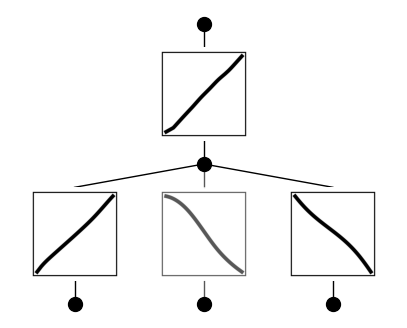

In [134]:
model.KAN.plot(beta=15)

In [135]:
#from functions.training import Early_stop_train

train_seq = Early_stop_train(model_MLP,optimizer_MLP,criterion)

train_seq.train_model(train_loader,val_loader)


Test set: Average loss: 1.9110, Accuracy: 0.0/200 (0%)
Epoch 1 Loss 1.887307 acc : 0.000000 stop count : 0
Test set: Average loss: 1.7699, Accuracy: 0.0/200 (0%)
Epoch 2 Loss 1.751073 acc : 0.000000 stop count : 0
Test set: Average loss: 1.6341, Accuracy: 0.0/200 (0%)
Epoch 3 Loss 1.619449 acc : 0.000000 stop count : 0
Test set: Average loss: 1.4929, Accuracy: 0.0/200 (0%)
Epoch 4 Loss 1.482226 acc : 0.000000 stop count : 0
Test set: Average loss: 1.3409, Accuracy: 0.0/200 (0%)
Epoch 5 Loss 1.334179 acc : 0.000000 stop count : 0
Test set: Average loss: 1.1765, Accuracy: 0.0/200 (0%)
Epoch 6 Loss 1.174060 acc : 0.000000 stop count : 0
Test set: Average loss: 1.0033, Accuracy: 0.0/200 (0%)
Epoch 7 Loss 1.006347 acc : 0.000000 stop count : 0
Test set: Average loss: 0.8334, Accuracy: 0.0/200 (0%)
Epoch 8 Loss 0.843739 acc : 0.000000 stop count : 0
Test set: Average loss: 0.6872, Accuracy: 0.0/200 (0%)
Epoch 9 Loss 0.707517 acc : 0.000000 stop count : 0
Test set: Average loss: 0.5869, Accu

In [136]:

train_seq_LSTM = Early_stop_train(LSTM_model,optimizer_LSTM,criterion)

train_seq_LSTM.train_model(train_loader,val_loader)


Test set: Average loss: 1.8038, Accuracy: 0.0/200 (0%)
Epoch 1 Loss 1.797427 acc : 0.000000 stop count : 0
Test set: Average loss: 1.6805, Accuracy: 0.0/200 (0%)
Epoch 2 Loss 1.697027 acc : 0.000000 stop count : 0
Test set: Average loss: 1.4685, Accuracy: 0.0/200 (0%)
Epoch 3 Loss 1.460029 acc : 0.000000 stop count : 0
Test set: Average loss: 0.8018, Accuracy: 0.0/200 (0%)
Epoch 4 Loss 0.822387 acc : 0.000000 stop count : 0
Test set: Average loss: 0.7563, Accuracy: 0.0/200 (0%)
Epoch 5 Loss 0.794545 acc : 0.000000 stop count : 0
Test set: Average loss: 0.8655, Accuracy: 0.0/200 (0%)
Epoch 6 Loss 0.920830 acc : 0.000000 stop count : 1
Test set: Average loss: 0.5352, Accuracy: 0.0/200 (0%)
Epoch 7 Loss 0.561033 acc : 0.000000 stop count : 0
Test set: Average loss: 0.7332, Accuracy: 0.0/200 (0%)
Epoch 8 Loss 0.753716 acc : 0.000000 stop count : 1
Test set: Average loss: 0.7756, Accuracy: 0.0/200 (0%)
Epoch 9 Loss 0.796678 acc : 0.000000 stop count : 2
Test set: Average loss: 0.7137, Accu

In [137]:
from functions.Error_mitigation import extrapolate_values
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# 선형 함수 정의
def linear_func(x, a, b):
    return a * x + b

# 지수 함수 정의
def exp_func(x, a, b, c):
    return b*a **(x) + c

# 데이터 피팅 및 외삽 함수
def extrapolate_values(y_data,x_data = np.array([1, 3, 5, 7])):
    # 선형 함수 피팅
    params_linear, _ = curve_fit(linear_func, x_data, y_data)
    a_linear, b_linear = params_linear
    y_linear_0 = linear_func(0, a_linear, b_linear)

    # 지수 함수 피팅 초기 추정값 및 범위 설정
    initial_guess = [0.8, 1, 1]
    bounds = ([0, -5, -np.inf], [1, 5, np.inf])

    params_exp, _ = curve_fit(exp_func, x_data, y_data, p0=initial_guess, bounds=bounds, maxfev=10000)
    a_exp, b_exp, c_exp = params_exp
    y_exp_0 = exp_func(0, a_exp, b_exp, c_exp)

    return y_linear_0, y_exp_0, params_linear, params_exp


In [153]:
y_lin_list = []
y_exp_list = []
y_list = []
x_list = []

for x,y in tqdm(val_dataset):
    y_linear_0, y_exp_0,_,_= extrapolate_values(x,x_data=input_list)
    y_lin_list.append(y_linear_0)
    y_exp_list.append(y_exp_0)
    y_list.append(y)
    x_list.append(float(x[0]))

x_list,y_lin_list,y_exp_list ,y_list = torch.tensor(x_list),torch.tensor(y_lin_list).float(),torch.tensor(y_exp_list).float(),torch.tensor(y_list).float()

  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\pop75\anaconda3\envs\Lee\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 200/200 [00:05<00:00, 34.85it/s]


In [154]:
Lin_loss = torch.nn.MSELoss()(y_lin_list,y_list).item()
exp_loss = torch.nn.MSELoss()(y_exp_list,y_list).item()
raw_loss = torch.nn.MSELoss()(x_list,y_list).item()



In [164]:
for x,y in val_loader:
    x

In [174]:
LSTM_output = torch.squeeze(LSTM_model(x))
KAN_output = torch.squeeze(model(x))
MLP_output = torch.squeeze(model_MLP(x))

MLP_loss = torch.nn.MSELoss()(MLP_output,y_list).item()
KAN_loss = torch.nn.MSELoss()(KAN_output,y_list).item()
LSTM_loss = torch.nn.MSELoss()(LSTM_output,y_list).item()


In [179]:
loss_list = {'lin':Lin_loss,'exp':exp_loss,'raw':raw_loss,'MLP':MLP_loss,'KAN':KAN_loss,'LSTM':LSTM_loss}

for name,loss in loss_list.items():
    print(f"{name} = {loss}")

lin = 0.03133983910083771
exp = 0.498531311750412
raw = 0.1450759470462799
MLP = 0.631984531879425
KAN = 2.7350988388061523
LSTM = 0.3321623206138611


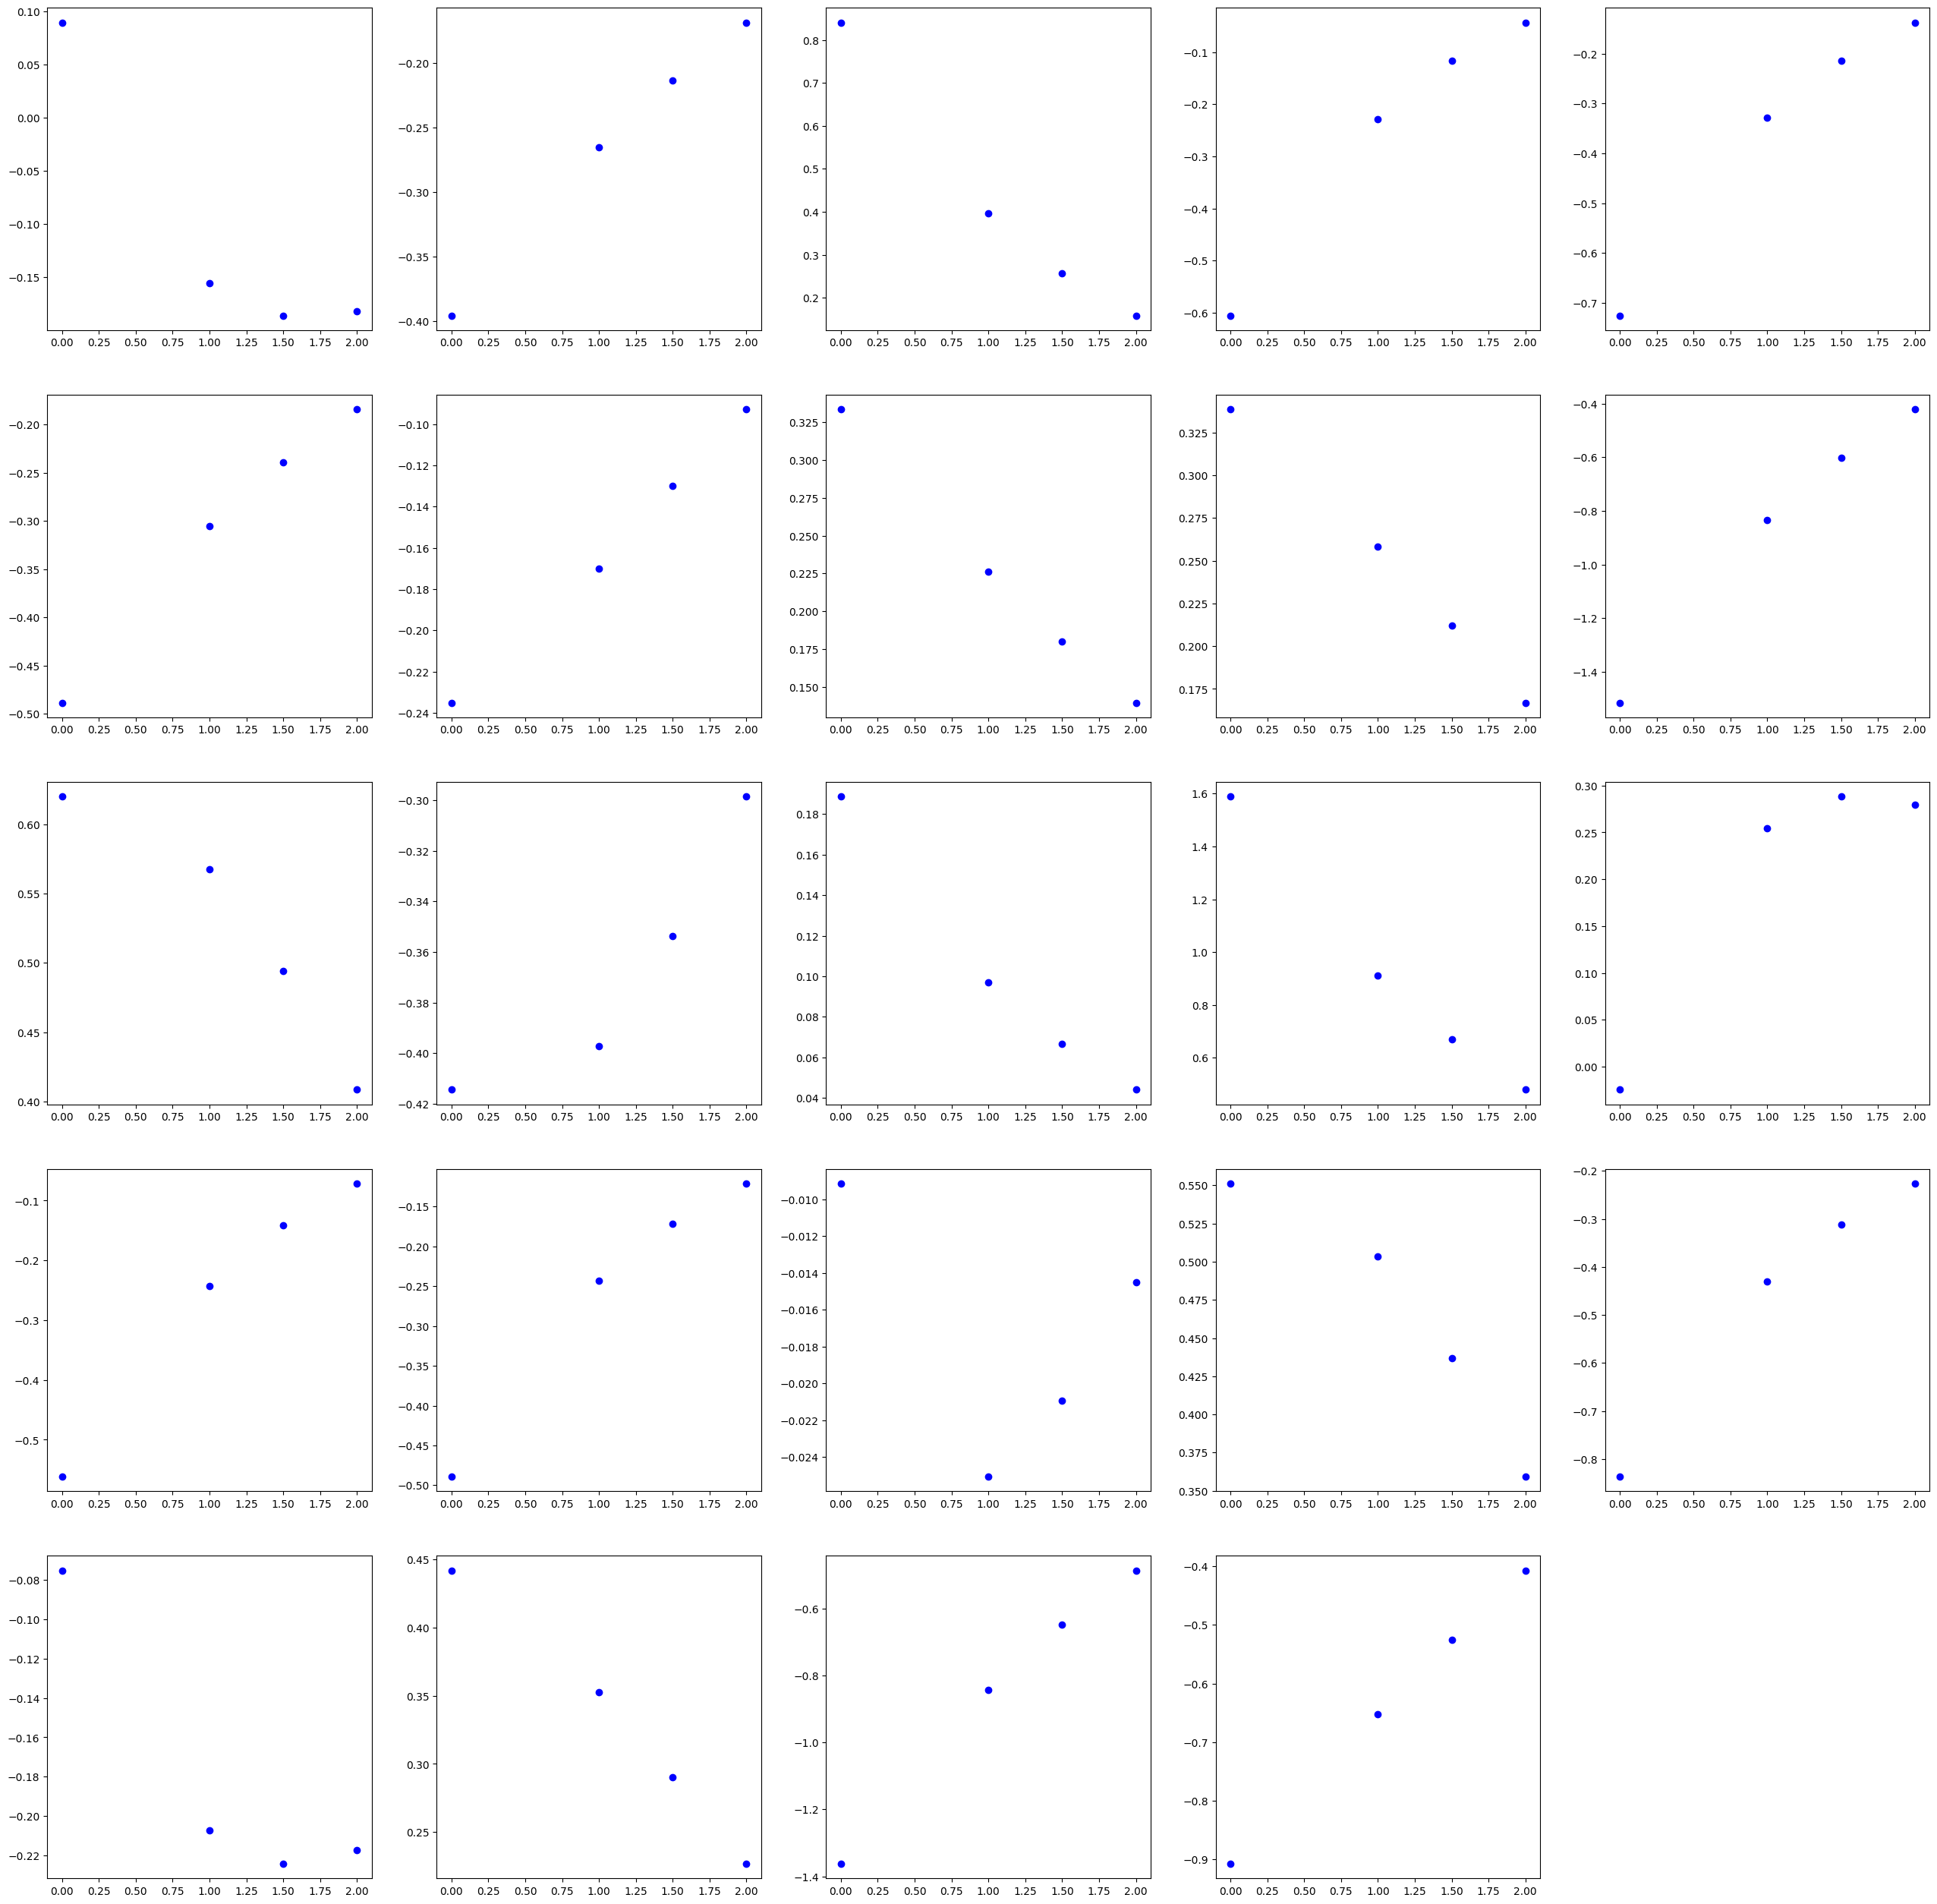

In [180]:
plt.figure(figsize=(32,32))
for index,(x,y) in enumerate(val_dataset):
    index = index+1
    if index <25:
        plt.subplot(5,5,index)
        plt.plot([0]+input_list,list([y])+list(x),'bo')
        index+=1
    else:
        break

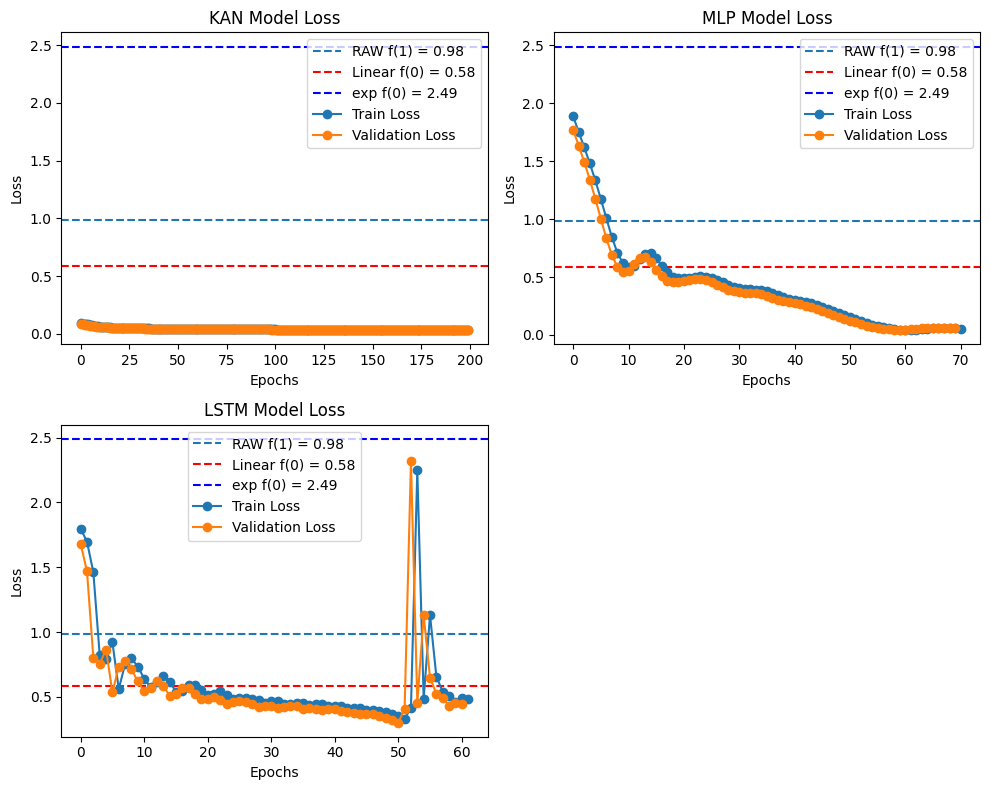

In [143]:
import matplotlib.pyplot as plt



# 예시 데이터
KAN_model_train_loss = train_seq_KAN.train_loss_list
KAN_model_val_loss = train_seq_KAN.loss_list
MLP_model_train_loss = train_seq.train_loss_list
MLP_model_val_loss = train_seq.loss_list
LSTM_model_train_loss = train_seq_LSTM.train_loss_list
LSTM_model_val_loss = train_seq_LSTM.loss_list







# KAN 모델 Loss 플롯
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")

plt.plot(KAN_model_train_loss, label='Train Loss', marker='o')
plt.plot(KAN_model_val_loss, label='Validation Loss', marker='o')
plt.title('KAN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MLP 모델 Loss 플롯
plt.subplot(2, 2, 2)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")
plt.plot(MLP_model_train_loss, label='Train Loss', marker='o')
plt.plot(MLP_model_val_loss, label='Validation Loss', marker='o')
plt.title('MLP Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MLP 모델 Loss 플롯
plt.subplot(2, 2, 3)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")
plt.plot(LSTM_model_train_loss, label='Train Loss', marker='o')
plt.plot(LSTM_model_val_loss, label='Validation Loss', marker='o')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


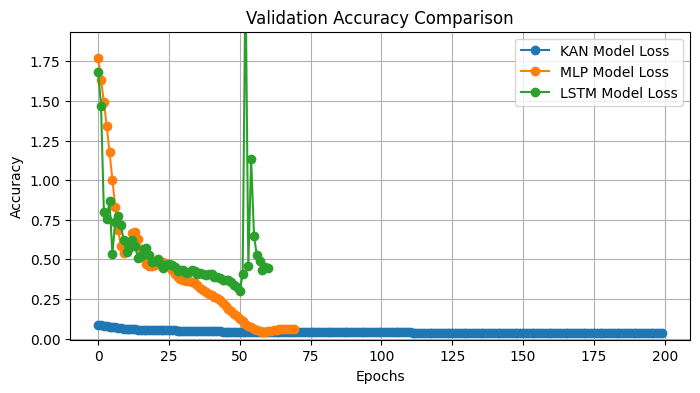

In [144]:
import matplotlib.pyplot as plt

# Epochs
# 정확도 플롯
plt.figure(figsize=(8, 4))
plt.plot(KAN_model_val_loss, label='KAN Model Loss', marker='o')
plt.plot(MLP_model_val_loss, label='MLP Model Loss', marker='o')
plt.plot(LSTM_model_val_loss, label='LSTM Model Loss', marker='o')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(np.min(MLP_model_train_loss)-0.05,np.max(MLP_model_train_loss)+0.05)
plt.show()